# Figure 1.f/g : Training efficiency

Goals : 

- Show that 3D models are more efficient in terms of training data needed to reach a certain accuracy, compared to 2D models.
  
(Also shows slight advantage of 3D models in terms of accuracy, and performance of self-supervised model.)

In [89]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
from pathlib import Path
from tifffile import imread
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import kruskal
import pyclesperanto_prototype as cle
from skimage.morphology import remove_small_objects
from stardist.matching import matching_dataset
sys.path.append("../..")

from utils import *
from plots import *

show_params()

Plot parameters (set in plots.py) : 
- COLORMAP : ████████
- DPI : 200
- Data path : C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK
- Font size : 20
- Title font size : 25.0
- Label font size : 20.0


In [91]:
# expanded colormap has darker and lighter shades for each original color (see get_shades in utils.py)
# See intensity parameter in get_shades to adjust the intensity of the shades
# The Cellpose color needs to be there twice, we insert it between color 1 and 2
# Same for StarDist, default color is COLORMAP[0]
temp_cmap = COLORMAP.copy()
temp_cmap.insert(2, COLORMAP[1])
temp_cmap.insert(1, COLORMAP[0])
temp_cmap[2], _ = get_shades(temp_cmap[3])
temp_cmap[0], _ = get_shades(temp_cmap[1])
EXPANDED_COLORMAP = []
for color in temp_cmap[:7]:
    colors = get_n_shades(color, 4)
    EXPANDED_COLORMAP.extend(colors)
EXPANDED_COLORMAP.extend(COLORMAP[7:])

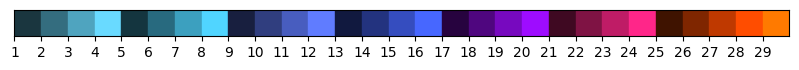

In [96]:
# show the colors in EXPANDED_COLORMAP
def show_colors(color_list):
    fig, ax = plt.subplots(figsize=(10, 2))
    for i, color in enumerate(color_list):
        ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))
    ax.set_xlim(0, len(color_list))
    ax.set_ylim(0, 1)
    ax.set_xticks(range(len(color_list)))
    ax.set_xticklabels(range(1, len(color_list) + 1))
    ax.set_yticks([])
    ax.set_aspect('equal')
    plt.show()

# Show the colors in EXPANDED_COLORMAP
show_colors(EXPANDED_COLORMAP)


In [92]:
SAVE_PLOTS_AS_PNG = False
SAVE_PLOTS_AS_SVG = True

## Data loading

In [93]:
image_folder = DATA_PATH / "RESULTS/SPLITS/Analysis/dataset_splits"
c5 = imread(image_folder / "c5.tif")
c3 = imread(image_folder / "c3.tif")
visual = imread(image_folder / "visual.tif")

gt_dict = {
    "visual": visual,
    "c3": c3,
    "c5": c5,
}

### Order data by model and split

In [94]:
def find_images(path, split):
    return list(path.glob(f"*{split}*.tif"))

#### Supervised models

In [95]:
visual_preds = {
    "Cellpose": {
        "1090": find_images(image_folder / "c1_5/cp", "1090")[0],
        "2080": find_images(image_folder / "c1_5/cp", "2080")[0],
        "6040": find_images(image_folder / "c1_5/cp", "6040")[0],
        "8020": find_images(image_folder / "c1_5/cp", "8020")[0],
    },
    "Cellpose - default": {
        "1090": find_images(image_folder / "c1_5/cp/default", "1090")[0],
        "2080": find_images(image_folder / "c1_5/cp/default", "2080")[0],
        "6040": find_images(image_folder / "c1_5/cp/default", "6040")[0],
        "8020": find_images(image_folder / "c1_5/cp/default", "8020")[0],
    },
    "StarDist - default": {
        "1090": find_images(image_folder / "c1_5/sd", "1090")[0],
        "2080": find_images(image_folder / "c1_5/sd", "2080")[0],
        "6040": find_images(image_folder / "c1_5/sd", "6040")[0],
        "8020": find_images(image_folder / "c1_5/sd", "8020")[0],
    },
    "StarDist": {
        "1090": find_images(image_folder / "c1_5/sd/tuned", "10")[0],
        "2080": find_images(image_folder / "c1_5/sd/tuned", "20")[0],
        "6040": find_images(image_folder / "c1_5/sd/tuned", "60")[0],
        "8020": find_images(image_folder / "c1_5/sd/tuned", "80")[0],
    },
    "SegResNet": {
        "1090": find_images(image_folder / "c1_5/segres", "1090")[0],
        "2080": find_images(image_folder / "c1_5/segres", "2080")[0],
        "6040": find_images(image_folder / "c1_5/segres", "6040")[0],
        "8020": find_images(image_folder / "c1_5/segres", "8020")[0],
    },
    "SwinUNetR": {
        "1090": find_images(image_folder / "c1_5/swin", "1090")[0],
        "2080": find_images(image_folder / "c1_5/swin", "2080")[0],
        "6040": find_images(image_folder / "c1_5/swin", "6040")[0],
        "8020": find_images(image_folder / "c1_5/swin", "8020")[0],
    },
}
c3_preds = {
    "Cellpose": {
        "1090": find_images(image_folder / "c1245_v/cp", "1090")[0],
        "2080": find_images(image_folder / "c1245_v/cp", "2080")[0],
        "6040": find_images(image_folder / "c1245_v/cp", "6040")[0],
        "8020" : find_images(image_folder / "c1245_v/cp", "8020")[0],
    },
    "Cellpose - default": {
        "1090": find_images(image_folder / "c1245_v/cp/default", "1090")[0],
        "2080": find_images(image_folder / "c1245_v/cp/default", "2080")[0],
        "6040": find_images(image_folder / "c1245_v/cp/default", "6040")[0],
        "8020": find_images(image_folder / "c1245_v/cp/default", "8020")[0],
    },
    "StarDist - default": {
        "1090": find_images(image_folder / "c1245_v/sd", "1090")[0],
        "2080": find_images(image_folder / "c1245_v/sd", "2080")[0],
        "6040": find_images(image_folder / "c1245_v/sd", "6040")[0],
        "8020": find_images(image_folder / "c1245_v/sd", "8020")[0],
    },
    "StarDist": {
        "1090": find_images(image_folder / "c1245_v/sd/tuned", "10")[0],
        "2080": find_images(image_folder / "c1245_v/sd/tuned", "20")[0],
        "6040": find_images(image_folder / "c1245_v/sd/tuned", "60")[0],
        "8020": find_images(image_folder / "c1245_v/sd/tuned", "80")[0],
    },
    "SegResNet": {
        "1090": find_images(image_folder / "c1245_v/segres", "1090")[0],
        "2080": find_images(image_folder / "c1245_v/segres", "2080")[0],
        "6040": find_images(image_folder / "c1245_v/segres", "6040")[0],
        "8020": find_images(image_folder / "c1245_v/segres", "8020")[0],
    },
    "SwinUNetR": {
        "1090": find_images(image_folder / "c1245_v/swin", "1090")[0],
        "2080": find_images(image_folder / "c1245_v/swin", "2080")[0],
        "6040": find_images(image_folder / "c1245_v/swin", "6040")[0],
        "8020": find_images(image_folder / "c1245_v/swin", "8020")[0],
    },
}
c5_preds = {
    "Cellpose": {
        "1090": find_images(image_folder / "c1-4_v/cp", "1090")[0],
        "2080": find_images(image_folder / "c1-4_v/cp", "2080")[0],
        "6040": find_images(image_folder / "c1-4_v/cp", "6040")[0],
        "8020" : find_images(image_folder / "c1-4_v/cp", "8020")[0],
    },
    "Cellpose - default": {
        "1090": find_images(image_folder / "c1-4_v/cp/default", "1090")[0],
        "2080": find_images(image_folder / "c1-4_v/cp/default", "2080")[0],
        "6040": find_images(image_folder / "c1-4_v/cp/default", "6040")[0],
        "8020": find_images(image_folder / "c1-4_v/cp/default", "8020")[0],
    },
    "StarDist - default": {
        "1090": find_images(image_folder / "c1-4_v/sd", "1090")[0],
        "2080": find_images(image_folder / "c1-4_v/sd", "2080")[0],
        "6040": find_images(image_folder / "c1-4_v/sd", "6040")[0],
        "8020": find_images(image_folder / "c1-4_v/sd", "8020")[0],
    },
    "StarDist": {
        "1090": find_images(image_folder / "c1-4_v/sd/tuned", "10")[0],
        "2080": find_images(image_folder / "c1-4_v/sd/tuned", "20")[0],
        "6040": find_images(image_folder / "c1-4_v/sd/tuned", "60")[0],
        "8020": find_images(image_folder / "c1-4_v/sd/tuned", "80")[0],
    },
    "SegResNet": {
        "1090": find_images(image_folder / "c1-4_v/segres", "1090")[0],
        "2080": find_images(image_folder / "c1-4_v/segres", "2080")[0],
        "6040": find_images(image_folder / "c1-4_v/segres", "6040")[0],
        "8020": find_images(image_folder / "c1-4_v/segres", "8020")[0],
    },
    "SwinUNetR": {
        "1090": find_images(image_folder / "c1-4_v/swin", "1090")[0],
        "2080": find_images(image_folder / "c1-4_v/swin", "2080")[0],
        "6040": find_images(image_folder / "c1-4_v/swin", "6040")[0],
        "8020": find_images(image_folder / "c1-4_v/swin", "8020")[0],
    },
}


IndexError: list index out of range

In [ ]:
# organize as DataFrame
df = pd.DataFrame()
splits = [visual_preds, c3_preds, c5_preds]
for i, gt_name in enumerate(gt_dict):
    preds = splits[i]
    for model_name in preds:
        for split in preds[model_name]:
            gt = gt_dict[gt_name]
            df = pd.concat([df, pd.DataFrame({
                "model": model_name,
                "split": split[:2] + "/" + split[2:],
                "gt": gt_name,
                "path": [preds[model_name][split]],
            })])
df.reset_index(inplace=True, drop=True)
df

In [ ]:
df.iloc[0].path # check if the paths are correct

### Add pretrained WNet3D splits to the data

In [ ]:
df.loc[len(df)] = ["WNet3D - Pretrained", "WNet - Artifacts", "visual", image_folder / "WNet/pretrained/visual_pred.tif"]
df.loc[len(df)] = ["WNet3D - Pretrained", "WNet - Artifacts", "c3", image_folder / "WNet/pretrained/c3_pred.tif"]
df.loc[len(df)] = ["WNet3D - Pretrained", "WNet - Artifacts", "c5", image_folder / "WNet/pretrained/c5_pred.tif"]
df

#### WNet3D - Order by splits

In [12]:
wnet_splits_preds = {
    "1090" : find_images(image_folder / "WNet/10", "pred"),
    "2080" : find_images(image_folder / "WNet/20", "pred"),
    "6040" : find_images(image_folder / "WNet/60", "pred"),
    "8020" : find_images(image_folder / "WNet/80", "pred"),
} # these are lists where each element is an image for a split (3 per split)

In [ ]:
for split, image_paths in wnet_splits_preds.items():
    split = split[:2] + "/" + split[2:]
    for i, path in enumerate(image_paths):
        df.loc[len(df)] = ["WNet3D", f"WNet - {split}", "visual", path]
df

In [14]:
model_names = ["StarDist - default", "StarDist", "Cellpose - default", "Cellpose", "SegResNet", "SwinUNetR", "WNet3D", "WNet3D - Pretrained"]

```{note}
For WNet3D, we compute two sets of scores :

- One on c3, c5 and ALL of visual, which contains some artifacts. This is "All data".
- One on c3, c5 and PART of visual, which does not contain artifacts. This is "No artifacts".

In [15]:
visual_slice = 50
visual_gt_no_artifact = gt_dict["visual"][:visual_slice,:,:]
wnet_c3_pred = imread(image_folder / "WNet/pretrained/c3_pred.tif")
wnet_c5_pred = imread(image_folder / "WNet/pretrained/c5_pred.tif")
wnet_visual_no_artifact = imread(image_folder / "WNet/pretrained/visual_pred.tif")[:visual_slice,:,:]

In [16]:
path_df = df.copy()

## F1 computation

### Pre-processing for SwinUNetR and SegResNet

In [17]:
# We use the same threshold for all splits, estimated from the training data from the supervised benchmark figure 
swin_params = {
    "thresh": 0.4,
    "spot_sigma": 0.65,
    "outline_sigma": 0.65,
}
segres_params = {
    "thresh": 0.3,
    "spot_sigma": 0.65,
    "outline_sigma": 0.65,
}
wnet_params = {
    "thresh": 0.6,
    "spot_sigma": 0.65,
    "outline_sigma": 0.65,
}

def models_instance_preprocessing(volume, params):
    volume = np.where(volume > params["thresh"], 1, 0)
    labels = cle.voronoi_otsu_labeling(volume, spot_sigma=params["spot_sigma"], outline_sigma=params["outline_sigma"])
    labels = remove_small_objects(np.array(labels), min_size=5)
    return labels

def wnet_preprocessing(volume, channel_foreground, params):
    # this should only be done on volumes with more than 3 dimensions
    if len(volume.shape) < 4:
        return volume
    volume = volume[channel_foreground]
    volume = np.where(volume > params["thresh"], 1, 0)
    labels = cle.voronoi_otsu_labeling(volume, spot_sigma=params["spot_sigma"], outline_sigma=params["outline_sigma"])
    return labels

In [18]:
# import napari
# viewer = napari.Viewer()
# # show visual gt and swin preprocessed for each split
# swin_path = df.iloc[9]
# swin_pred = imread(swin_path.path)
# viewer.add_labels(gt_dict["c3"], name="c3_gt")
# swin_pred_processed = models_instance_preprocessing(swin_pred, swin_params)
# viewer.add_labels(swin_pred_processed, name="swin_pred")
# viewer.add_image(np.swapaxes(swin_pred), name="swin_pred_raw", colormap="turbo")

In [19]:
df.set_index(
    [
    "model",
    # "split"
    ],
    inplace=True
             )

### F1 score computation

In [101]:
F1_THRESH = 0.5

In [ ]:
def model_f1_across_splits(df, verbose=False):
    f1_df = pd.DataFrame(columns=["Score", "Model", "Split", "GT"])
    for model in model_names:
        for split in df.loc[model]["split"].unique():
            for i, row in df.loc[model][df.loc[model]["split"] == split].iterrows():
                gt = gt_dict[row["gt"]]
                pred = imread(row.path)
                if model == "SwinUNetR":
                    pred = models_instance_preprocessing(pred, swin_params)
                if model == "SegResNet":
                    pred = models_instance_preprocessing(pred, segres_params)
                if model == "WNet3D":
                    # look into path for foreground channel : c0 indicates first channel is foreground, c1 indicates second channel is foreground
                    channel = 1 if "c1" in str(row.path) else 0
                    pred = wnet_preprocessing(pred, channel, wnet_params)
                    if row["gt"] == "visual":
                        pred = pred[:visual_slice,:,:]
                        gt = gt[:visual_slice,:,:]
                if verbose:
                    print(f"Model: {model}, Split: {split}, GT: {row['gt']}")
                    print(f"Image shape: {pred.shape}")
                    print(f"GT shape: {gt_dict[row['gt']].shape}")
                ####
                # gt = np.where(gt > 0, 1, 0)
                # pred = np.where(pred > 0, 1, 0)
                # f1 = dice_coeff(gt, pred)
                stats = matching_dataset(
                gt, pred, thresh=F1_THRESH, show_progress=False
                )
                f1 = stats["f1"]
                ###
                if verbose:
                    print(f"F1 @ {F1_THRESH}: {f1}")
                    print("_"*20)
                f1_df.loc[len(f1_df)] = [f1, model, split, row["gt"]]
    return f1_df

In [ ]:
f1_df = model_f1_across_splits(df, verbose=True)

In [ ]:
f1_df

### WNet3D - No artifacts

In [ ]:
wnet_preds_no_artifacts = { # No artifacts
    "WNet3D - No artifacts": {
        "visual": wnet_visual_no_artifact,
        "c3": wnet_c3_pred,
        "c5": wnet_c5_pred,
    }
}
gt_dict_no_artifacts = {
    "visual": visual_gt_no_artifact,
    "c3": c3,
    "c5": c5,
}
for split in wnet_preds_no_artifacts:
    for image in wnet_preds_no_artifacts[split]:
        gt = gt_dict_no_artifacts[image]
        pred = wnet_preds_no_artifacts[split][image]
        # gt = np.where(gt > 0, 1, 0)
        # pred = np.where(pred > 0, 1, 0)
        # f1 = dice_coeff(gt, pred)
        stats = matching_dataset(
            gt, pred, thresh=F1_THRESH, show_progress=False
        )
        f1 = stats["f1"]
        print(f"Split: {split}, Image: {image}, Score: {f1}")
        f1_df.loc[len(f1_df)] = [f1, "WNet3D - Pretrained", split, image]

### Detailed stats 
Shows means and stds of select splits for manuscript. 
This is the data was used in the text of the manuscript.

In [ ]:
score_df_8020 = f1_df[f1_df["Split"] == "80/20"]
score_df_8020.groupby("Model", sort=False).agg({"Score": ["mean", "std"]}).sort_values(("Score", "mean"), ascending=False)

In [ ]:
score_df_1090 = f1_df[f1_df["Split"] == "10/90"]
score_df_1090.groupby("Model", sort=False).agg({"Score": ["mean", "std"]}).sort_values(("Score", "mean"), ascending=False)

In [ ]:
score_df_wnet = f1_df[f1_df["Model"] == "WNet3D - Pretrained"]
score_df_wnet.groupby("Split").agg({"Score": ["mean", "std"]})

In [ ]:
score_df_wnet_trained_on_subsets = f1_df[f1_df["Model"] == "WNet3D"]
score_df_wnet_trained_on_subsets.groupby("Split").agg({"Score": ["mean", "std"]})

## Plots

In [28]:
f1_df['Model_Split'] = f1_df['Model'] + ' (' + f1_df['Split'].astype(str) + ')'

In [108]:
######## MOCK DATA FOR TESTING ########
# will be removed once run on real data
splits_mock = ["1", "1", "1", "2", "2", "2", "3", "3", "3", "4", "4", "4"]
gt_mock = ["GT 1", "GT 2", "GT 3", "GT 1", "GT 2", "GT 3", "GT 1", "GT 2", "GT 3", "GT 1", "GT 2", "GT 3"]
def model_mock(id, num=12):
    return [f"Model {id}"] * num
def scores_mock(length):
    return np.random.rand(length).tolist()

mock_data_df = pd.DataFrame({
    "Model": model_mock(1) + model_mock(2) + model_mock(3) + model_mock(4) + model_mock(5) + model_mock(6) + model_mock(7) + model_mock(8, 6),
    "Split": splits_mock + splits_mock + splits_mock + splits_mock + splits_mock + splits_mock + splits_mock + ["1", "1", "1", "2", "2", "2"],
    "GT": gt_mock + gt_mock + gt_mock + gt_mock + gt_mock + gt_mock + gt_mock + ["GT 1", "GT 2", "GT 3", "GT 1", "GT 2", "GT 3"],
    "Score": scores_mock(len(splits_mock)) + scores_mock(len(splits_mock)) + scores_mock(len(splits_mock)) + scores_mock(len(splits_mock))+ scores_mock(len(splits_mock))+ scores_mock(len(splits_mock))+ scores_mock(len(splits_mock))+ scores_mock(6)
}).sort_values(by=["Model", "Split", "GT"])

mock_data_df
#######################################

,Model,Split,GT,Score
0,Model 1,1,GT 1,0.025535
1,Model 1,1,GT 2,0.964174
2,Model 1,1,GT 3,0.480924
3,Model 1,2,GT 1,0.116024
4,Model 1,2,GT 2,0.840597
...,...,...,...,...
85,Model 8,1,GT 2,0.748133
86,Model 8,1,GT 3,0.375378
87,Model 8,2,GT 1,0.561062
88,Model 8,2,GT 2,0.098016


### Matplotlib-only version

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


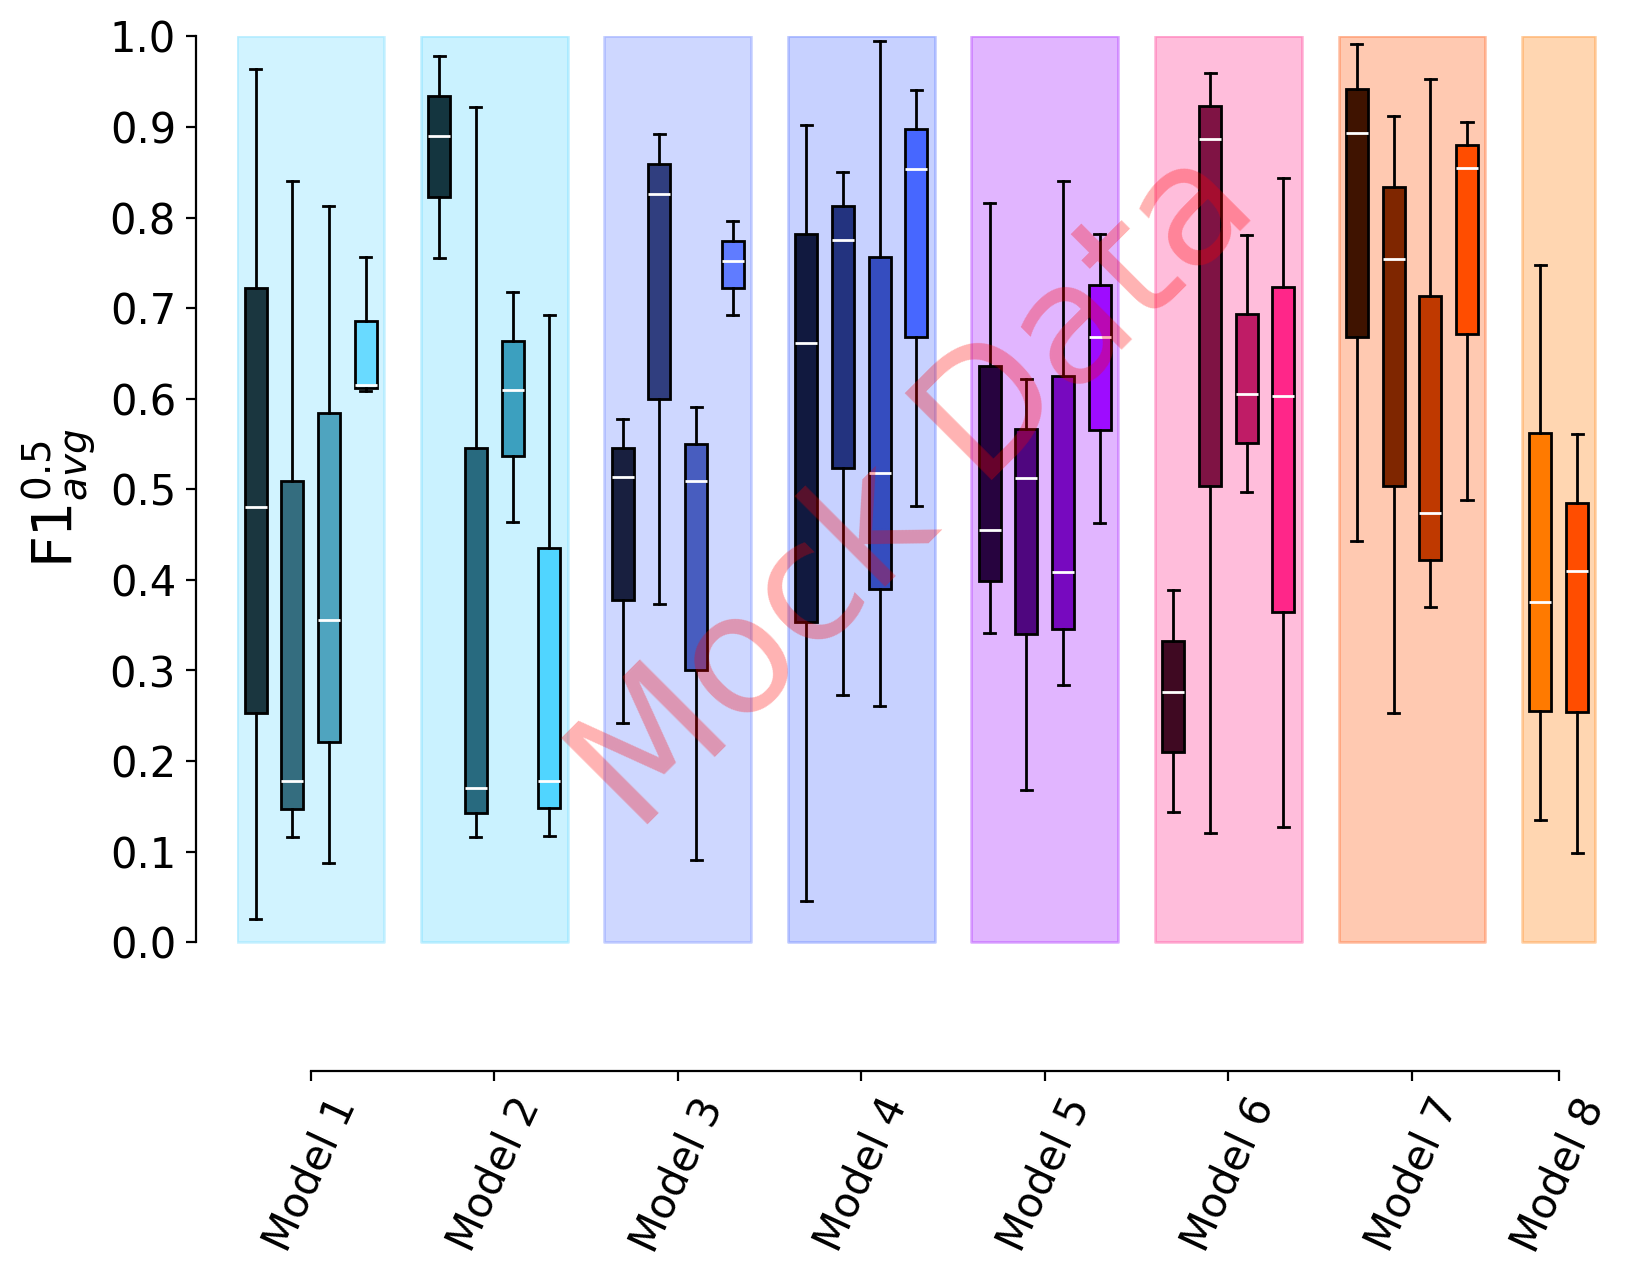

In [109]:
models = mock_data_df["Model"].unique()
model_splits = {model: mock_data_df[mock_data_df["Model"] == model]["Split"].unique() for model in models}

data = []
labels = []
for model in models:
    splits = model_splits[model]
    for split in splits:
        scores_vals = mock_data_df[(mock_data_df["Model"] == model) & (mock_data_df["Split"] == split)]["Score"].values
        data.append(scores_vals)
        labels.append(f'{model}-{split}')
    data.append([])  # add a gap between models
    labels.append('') 

fig, ax = plt.subplots(figsize=(9, 6), dpi=DPI)
box = ax.boxplot(data, patch_artist=True, widths=0.6)

# set boxplot colors, minding the gap
colors = EXPANDED_COLORMAP + EXPANDED_COLORMAP[-2:]
color_index = 0
for i in range(len(box['boxes'])):
    if len(data[i]) == 0:
        continue
    box['boxes'][i].set_facecolor(colors[color_index])
    color_index += 1

# set median to white for better visibility
for median in box['medians']:
    median.set(color='white', linewidth=1)

# shade each group of splits
group_start = 0
for i, model in enumerate(models):
    splits = model_splits[model]
    group_end = group_start + len(splits)
    # use 4th color, unless we reach the end of the colors list, where we have Wnet3d again
    c= colors[i*4+3] if i < 7 else colors[-1]
    ax.fill_between(
        x=[group_start + 0.5, group_end + 0.5],
        y1=0,
        y2=1,
        color=c,
        alpha=0.3 
    )
    group_start = group_end + 1

# move and group xticks
model_labels = []
model_positions = []
model_labels = []
model_positions = []
for i, model in enumerate(models):
    model_labels.append(model)
    offset = 5/2 if i < 7 else 3/2
    model_positions.append(i * 5 + offset)

ax.set_xticks(model_positions)
ax.set_xticklabels(model_labels, ha='center')

# the usual formatting
ax.tick_params(axis="both", which="major", labelsize=LEGEND_FONT_SIZE)
ax.tick_params(axis = 'x',   rotation = 65)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.ylim([-0.02,1])
ax.set_yticks(np.arange(0,1.1,0.1))
sns.despine(
    left=False,
    right=True,
    bottom=False,
    top=True,
    trim=True,
    offset={"bottom": 40, "left": 15},
)
legend = ax.legend(fontsize=LEGEND_FONT_SIZE, bbox_to_anchor=BBOX_TO_ANCHOR, loc=LOC)
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)
legend.get_frame().set_alpha(0)
ax.set_xlabel("", fontsize=LABEL_FONT_SIZE)
ax.set_ylabel(rf"F1$_{{avg}}^{{{F1_THRESH}}}$", fontsize=LABEL_FONT_SIZE)
plt.legend([],[], frameon=False)

####### TEMP WATERMARK #######
ax.text(
    x=len(box['boxes'])/2, 
    y=0.5,
    s="Mock Data",
    color='red',
    rotation=45,
    alpha=0.3, 
    fontsize=60,   
    ha='center',   
    va='center'    
)
###############################


plt.show()

if SAVE_PLOTS_AS_PNG:
    fig.savefig("Label_efficiency.png", dpi=DPI, bbox_inches="tight")
if SAVE_PLOTS_AS_SVG:
    fig.savefig("Label_efficiency.svg", bbox_inches="tight")

### Seaborn version (deprecated)

#### All models (hard to read)

In [ ]:
fig, ax = plt.subplots(figsize=(9, 6), dpi=DPI)
sns.boxplot(
    data=f1_df,
    x="Model", 
    y="Score", 
    hue="Model_Split", 
    ax=ax, 
    palette=EXPANDED_COLORMAP,
    # dodge=False,
    )
for i, artist in enumerate(ax.artists): # try to center the boxplot on xticks
    for j in range(i*6,i*6+6):
        line = ax.lines[j]
        line.set_color(artist.get_facecolor())
        if j % 6 == 4: 
            x, y = line.get_xydata()[0]
            x_center = i // 2 
            if i % 2: 
                line.set_xdata([x_center + 0.2, x_center + 0.2, x, x_center + 0.2])
            else:  
                line.set_xdata([x_center - 0.2, x_center - 0.2, x, x_center - 0.2])

ax.tick_params(axis="both", which="major", labelsize=LEGEND_FONT_SIZE)
ax.tick_params(axis = 'x',   rotation = 65)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.ylim([-0.02,1])
ax.set_yticks(np.arange(0,1.1,0.1))
sns.despine(
    left=False,
    right=True,
    bottom=False,
    top=True,
    trim=True,
    offset={"bottom": 40, "left": 15},
)
legend = ax.legend(fontsize=LEGEND_FONT_SIZE, bbox_to_anchor=BBOX_TO_ANCHOR, loc=LOC)
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)
legend.get_frame().set_alpha(0)
ax.set_xlabel("", fontsize=LABEL_FONT_SIZE)
ax.set_ylabel("F1 score", fontsize=LABEL_FONT_SIZE)
plt.legend([],[], frameon=False)
plt.show()

if SAVE_PLOTS_AS_PNG:
    fig.savefig("Label_efficiency.png", dpi=DPI, bbox_inches="tight")
if SAVE_PLOTS_AS_SVG:
    fig.savefig("Label_efficiency.svg", bbox_inches="tight")

### Legend

In [ ]:
fig_leg = plt.figure(figsize=(3, 2))
ax_leg = fig_leg.add_subplot(111)
ax_leg.legend(handles=legend.legend_handles, labels=[text.get_text() for text in legend.texts])
ax_leg.axis('off')
plt.show()
if SAVE_PLOTS_AS_PNG:
    fig_leg.savefig("Label_efficiency_legend.png", dpi=DPI, bbox_inches="tight")
if SAVE_PLOTS_AS_SVG:
    fig_leg.savefig("Label_efficiency_legend.svg", bbox_inches="tight")

#### Self-supervised models

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=DPI)
wnet_models = ["WNet3D", "WNet3D - Pretrained"]
scores_df_selfsupervised = f1_df[f1_df["Model"].isin(wnet_models)]
sns.boxplot(
    data=scores_df_selfsupervised,
    x="Model", 
    y="Score", 
    hue="Model_Split", 
    ax=ax, 
    palette=EXPANDED_COLORMAP[20:]
    # dodge=False,
    )
for i, artist in enumerate(ax.artists): # try to center the boxplot on xticks
    for j in range(i*6,i*6+6):
        line = ax.lines[j]
        line.set_color(artist.get_facecolor())
        if j % 6 == 4: 
            x, y = line.get_xydata()[0]
            x_center = i // 2 
            if i % 2: 
                line.set_xdata([x_center + 0.2, x_center + 0.2, x, x_center + 0.2])
            else:  
                line.set_xdata([x_center - 0.2, x_center - 0.2, x, x_center - 0.2])

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(axis="both", which="major", labelsize=LEGEND_FONT_SIZE)
ax.tick_params(axis = 'x',   rotation = 65)
plt.ylim([-0.02,1])
ax.set_yticks(np.arange(0,1.1,0.1))
sns.despine(
    left=False,
    right=True,
    bottom=False,
    top=True,
    trim=True,
    offset={"bottom": 40, "left": 15},
)
legend = ax.legend(fontsize=LEGEND_FONT_SIZE, bbox_to_anchor=BBOX_TO_ANCHOR, loc=LOC)
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)
legend.get_frame().set_alpha(0)
ax.set_xlabel("", fontsize=LABEL_FONT_SIZE)
ax.set_ylabel("F1", fontsize=LABEL_FONT_SIZE)
plt.legend([],[], frameon=False)
plt.show()

if SAVE_PLOTS_AS_PNG:
    fig.savefig("Label_efficiency_selfsup.png", dpi=DPI, bbox_inches="tight")
if SAVE_PLOTS_AS_SVG:
    fig.savefig("Label_efficiency_selfsup.svg", bbox_inches="tight")

### Boxplots for each model

In [ ]:
models_dfs = [f1_df[f1_df["Model"] == model].copy() for model in model_names]
save_path = Path("label_efficiency")
save_path.mkdir(exist_ok=True)
for i, model in enumerate(model_names):
    print(model)
    # figsize_width = 1 if model != "WNet - Ours" else 0.33 # does not accept float values
    fig, ax = plt.subplots(figsize=(1, 6), dpi=DPI)
    df = models_dfs[i]
    sns.boxplot(
        data=df,
        x="Model_Split", 
        y="Score", 
        hue="Split", 
        ax=ax, 
        palette=EXPANDED_COLORMAP[0+4*i:4+4*i],
    )
    ax.tick_params(axis = 'x',   rotation = 45)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.tick_params(axis="both", which="major", labelsize=LEGEND_FONT_SIZE)
    ax.set_yticks(np.arange(0,1.1,0.1))
    ax.set_ylim([-0.02,1])
    sns.despine(
        left=False,
        right=True,
        bottom=False,
        top=True,
        trim=True,
        offset={"bottom": 40, "left": 15},
        ax=ax
    )
    ax.set_xticklabels("", fontsize=LABEL_FONT_SIZE)
    ax.set_xlabel("", fontsize=LABEL_FONT_SIZE)
    ax.set_ylabel("F1", fontsize=LABEL_FONT_SIZE)
    ax.legend([],[], frameon=False)
    ax.patch.set_alpha(0)
    legend = ax.get_legend()
    if legend:
        legend.remove()
    # ax.set_title(model, fontsize=LABEL_FONT_SIZE)
    fig.patch.set_alpha(0)
    plt.show()
    if SAVE_PLOTS_AS_PNG:
        fig.savefig(f"{str(save_path)}/Label_efficiency_{model}.png", dpi=DPI, bbox_inches="tight")
    if SAVE_PLOTS_AS_SVG:
        fig.savefig(f"{str(save_path)}/Label_efficiency_{model}.svg", bbox_inches="tight")

### Zoom-in for rightmost models

In [ ]:
# same as above with Swin and WNet and y axis on the right
fig, ax = plt.subplots(figsize=(3, 6), dpi=DPI)
zoom_df = f1_df[f1_df["Model"].isin(["SwinUNetR", "WNet3D"])]
sns.boxplot(data=zoom_df, x="Model", y="Score", hue="Split", ax=ax, palette=EXPANDED_COLORMAP[16:], dodge=True)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(axis="both", which="major", labelsize=LEGEND_FONT_SIZE)
ax.tick_params(axis = 'x',   rotation = 45,)
# ax.set_ylim([0.8,0.85])
# ax.set_yticks(np.arange(0.8,0.86,0.01))
ax.set_ylim([0.55,0.95])
ax.set_yticks(np.arange(0.55,0.96,0.05))
ax.set_xlabel("", fontsize=LABEL_FONT_SIZE)
ax.set_ylabel("F1", fontsize=LABEL_FONT_SIZE)
ax.legend_.remove()
sns.despine(
    left=False,
    right=True,
    bottom=False,
    top=True,
    trim=True,
    offset={"bottom": 40, "right": 15},
)
# legend = ax.legend(fontsize=LEGEND_FONT_SIZE, bbox_to_anchor=BBOX_TO_ANCHOR, loc=LOC)
# legend.get_frame().set_alpha(0)
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

if SAVE_PLOTS_AS_PNG:
    fig.savefig("Label_efficiency_SWIN_WNET_zoom.png", dpi=DPI, bbox_inches="tight")
if SAVE_PLOTS_AS_SVG:
    fig.savefig("Label_efficiency_SWIN_WNET_zoom.svg", bbox_inches="tight")

## Statistical tests

Here we run a Kruskal-Wallis test to assess if all models differ from each other, when performance is averaged across splits. 

### Performance across models


In [ ]:
f1_df

### Boxplot of model performance across all splits

In [ ]:
from plots import _format_plot

fig, ax = plt.subplots(figsize=(8, 8), dpi=DPI)
test_df = f1_df[f1_df["Split"] != "WNet - Artifacts"]
test_df = test_df.groupby("Model", sort=False).Score.apply(list).reset_index()
sns.boxplot(data=f1_df, hue="Model", y="Score", palette=temp_cmap, ax=ax)
_format_plot(ax, xlabel="Model", ylabel="F1", title="F1 across splits")
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)
plt.show()

if SAVE_PLOTS_AS_PNG:
    fig.savefig("Label_efficiency_all_models_pooled.png", dpi=DPI)
if SAVE_PLOTS_AS_SVG:
    fig.savefig("Label_efficiency_all_models_pooled.svg", bbox_inches="tight")

In [ ]:
print(kruskal(*test_df.Score.tolist()))

### p-values heatmap - Default notation

In [ ]:
from scikit_posthocs import posthoc_conover
import matplotlib.colors as colors
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(8, 8), dpi=DPI)
results = posthoc_conover(f1_df, val_col="Score", group_col="Model", p_adjust="holm")

low_color = COLORMAP[0]
mid_color = COLORMAP[1]
high_color = COLORMAP[2]
equals_1_color = COLORMAP[3]

levels = [0, 0.05, 0.06, 0.99, 1]
colors_list = [low_color, mid_color, high_color, high_color, equals_1_color]
cmap = colors.LinearSegmentedColormap.from_list("", list(zip(levels, colors_list)))
norm = colors.Normalize(vmin=0, vmax=1)

diag = np.diag_indices(results.shape[0])
results.values[diag] = np.nan
sns.heatmap(results, annot=True, cmap=cmap, norm=norm, cbar=False, fmt=".4f", linewidths=0.5, ax=ax)

patches = [mpatches.Patch(color=low_color, label='Above 0 (significant)'),
           mpatches.Patch(color=mid_color, label='Below 0.05 (significant)'),
           mpatches.Patch(color=high_color, label='Above 0.05 (not significant)'),
           mpatches.Patch(color=equals_1_color, label='Equals 1 (not significant)')]

ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# transparent background
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

if SAVE_PLOTS_AS_PNG:
    plt.savefig("Label_efficiency_posthoc_conover.png", dpi=DPI, bbox_inches="tight")
if SAVE_PLOTS_AS_SVG:
    plt.savefig("Label_efficiency_posthoc_conover.svg", bbox_inches="tight")

### p-values heatmap - Scientific notation

In [ ]:
from scikit_posthocs import posthoc_conover
import matplotlib.colors as colors
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(8, 8), dpi=DPI)
results = posthoc_conover(f1_df, val_col="Score", group_col="Model", p_adjust="holm")

low_color = COLORMAP[0]
mid_color = COLORMAP[1]
high_color = COLORMAP[2]
equals_1_color = COLORMAP[3]

levels = [0, 0.05, 0.06, 0.99, 1]
colors_list = [low_color, mid_color, high_color, high_color, equals_1_color]
cmap = colors.LinearSegmentedColormap.from_list("", list(zip(levels, colors_list)))
norm = colors.Normalize(vmin=0, vmax=1)

diag = np.diag_indices(results.shape[0])
results.values[diag] = np.nan
sns.heatmap(results, annot=True, cmap=cmap, norm=norm, cbar=False, fmt=".2e", linewidths=0.5, ax=ax)

patches = [mpatches.Patch(color=low_color, label='Above 0 (significant)'),
           mpatches.Patch(color=mid_color, label='Below 0.05 (significant)'),
           mpatches.Patch(color=high_color, label='Above 0.05 (not significant)'),
           mpatches.Patch(color=equals_1_color, label='Equals 1 (not significant)')]

ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# transparent background
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

if SAVE_PLOTS_AS_PNG:
    plt.savefig("Label_efficiency_posthoc_conover_sci.png", dpi=DPI, bbox_inches="tight")
if SAVE_PLOTS_AS_SVG:
    plt.savefig("Label_efficiency_posthoc_conover_sci.svg", bbox_inches="tight")

## Unused

In [ ]:
test = f1_df.copy()
test["Split"].apply(lambda x: x.split("/")[0][-3:]).values

In [ ]:
f1_df

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Fit a linear mixed effects model
mlm_df = f1_df.copy()
mlm_df["Data_percentage"] = mlm_df["Split"].apply(lambda x: x.split("/")[0][-3:])
# replace "cts" by 100 in the Data_percentage column
mlm_df["Data_percentage"] = mlm_df["Data_percentage"].replace("cts", 100)
mlm_df["Data_percentage"] = mlm_df["Data_percentage"].astype(int)
mlm_df

In [ ]:
sns.scatterplot(data=mlm_df, x="Data_percentage", y="Score", hue="Model", style="GT")

In [ ]:
sns.scatterplot(data=mlm_df, x="Data_percentage", y="Score", hue="GT", legend=False)

In [ ]:
model = smf.mixedlm("Score ~ Data_percentage + C(Model) + C(GT)", mlm_df.copy(), groups="Model")
result = model.fit()

# Create a DataFrame to hold the p-values
pvalues = pd.DataFrame(result.pvalues, columns=["p-value"])
result.summary()

In [ ]:
# use non-parametric repeated measures ANOVA
from scipy.stats import friedmanchisquare

test_df = f1_df[f1_df["Model"] != "WNet3D - Pretrained"].copy()
test_df = test_df.groupby("Model", sort=False)["Score"]

fried_stats, p_value = friedmanchisquare(*test_df.apply(list))

print(f"Friedman test p-value: {p_value}, statistic: {fried_stats}")